Importing Libraries

In [1]:
from tqdm import tqdm 
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree
from itertools import combinations
import open3d as o3d

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
from collections import deque
from tqdm import tqdm
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


File Paths

In [2]:
org_path="/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"
# org_path="G:/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"

object_name="dustbin"

test_input_path=org_path+"test_images/"+object_name+"/"
test_output_path=org_path+"test_outputs/"
test_3d_path=org_path+"test_3d/"

left_path = test_input_path+"im0.png"
right_path = test_input_path+"im1.png"
# test_path= "/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im0.png"

Accessory Functions

In [3]:

def load_image_to_rgb(image_path):
    """Load an image from path and return as RGB numpy array."""
    img = Image.open(image_path)
    return np.array(img.convert('RGB'))

In [4]:

def display_image_array(img_array):
    """Display a numpy image array (2D or 3D) without axes."""
    plt.figure()
    if len(img_array.shape) == 3:  # RGB image
        plt.imshow(img_array)
    else:  # Grayscale
        plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display_2x2_grid(images, figsize=(10, 10)):
    
    if len(images) != 4:
        raise ValueError("Exactly 4 images required")
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()  # Flatten to 1D array for easy indexing
    
    # Display each image with appropriate colormap
    for i, (img, ax) in enumerate(zip(images, axes)):
        if len(img.shape) == 3:  # RGB image
            ax.imshow(img)
        elif len(img.shape) == 2:  # Grayscale image
            ax.imshow(img, cmap='gray')
        else:
            raise ValueError(f"Image {i+1} has invalid shape {img.shape}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [6]:


def resize_image_array(image_array, scale_factor):
    # Convert array to PIL Image
    if len(image_array.shape) == 2:
        # Grayscale image
        img = Image.fromarray(image_array)
    elif len(image_array.shape) == 3:
        # RGB/RGBA image
        img = Image.fromarray(image_array.astype('uint8'))
    else:
        raise ValueError("Input array must be 2D (grayscale) or 3D (color)")
    
    # Calculate new dimensions
    width, height = img.size
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Resize using Lanczos resampling (high quality)
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Convert back to numpy array
    resized_array = np.array(resized_img)
    
    # Preserve original dtype for grayscale
    if len(image_array.shape) == 2:
        resized_array = resized_array.astype(image_array.dtype)
    
    return resized_array

In [7]:
def plot_disp_array(data_array):
    plt.figure(figsize=(8, 6))
    img = plt.imshow(data_array, cmap='viridis')
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Value Scale', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_viridis_matrix(matrix):
    # Visualize results
    plt.figure(figsize=(12, 5))
    plt.imshow(matrix, cmap='viridis')
    plt.title('Matrix')
    plt.colorbar()

In [9]:
def rgb_to_luminance(img_array):
    """Convert RGB image array to luminance (grayscale) using standard weights."""
    if len(img_array.shape) == 2:
        return img_array  # Already grayscale
    gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    return gray.astype(np.int_)

Plotting Functions

In [10]:

def plot_colorized_segments(array_2d):
    
    # Calculate value occurrences (excluding zeros from frequency calculation)
    flat_array = array_2d.flatten()
    value_counts = Counter(flat_array)
    unique_values = np.array(sorted(value_counts.keys()))
    
    # Separate zero and non-zero values
    zero_exists = 0 in value_counts
    non_zero_values = unique_values[unique_values != 0] if zero_exists else unique_values
    
    # Create Viridis colormap for non-zero values
    if len(non_zero_values) > 0:
        non_zero_counts = np.array([value_counts[v] for v in non_zero_values])
        norm_counts = (non_zero_counts - non_zero_counts.min()) / \
                    (non_zero_counts.max() - non_zero_counts.min() + 1e-10)
        cmap = plt.cm.viridis # type: ignore
        
        # Assign colors (using 0.1-0.9 range of Viridis to avoid extremes)
        color_dict = {val: cmap(0.1 + 0.8*norm_counts[i]) 
                     for i, val in enumerate(non_zero_values)}
    
    # Always set 0 to black
    if zero_exists:
        color_dict[0] = (0, 0, 0, 1)  # Black with full opacity
    
    # Create RGB image
    rgb_image = np.zeros((*array_2d.shape, 3))
    for val in color_dict:
        rgb_image[array_2d == val] = color_dict[val][:3]  # Exclude alpha channel
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # return color_dict  # Optional: return the color mapping

In [11]:

def plot_value_occurrences(array_2d):
    """
    Plot the occurrence of values in a 2D array as a histogram.
    
    Args:
        array_2d: 2D numpy array with non-negative integer values
    """
    # Flatten array and count occurrences
    flat_array = array_2d.flatten()
    value_counts = Counter(flat_array)
    
    # Extract values and counts
    values = np.array(sorted(value_counts.keys()))
    counts = np.array([value_counts[v] for v in values])
    
    if values[0]==0:
        values=values[1:]
        counts=counts[1:]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    bars = plt.bar(values, counts, color='skyblue', edgecolor='black')
    
    # Customize plot
    plt.xlabel('Value')
    plt.ylabel('Occurrences')
    plt.title('Value Occurrences in 2D Array')
    plt.grid(axis='y', alpha=0.5)
    
    # If there are many values, rotate x-axis labels
    if len(values) > 20:
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

Texture Segmentation

In [12]:

def texture_segmentation(image_array, threshold, scale_region):
    
    texture = 1
    texture_dict = {}
    labeled_array = np.zeros_like(image_array, dtype=np.uint16)
    height, width = image_array.shape
    
    scale = int (round(np.sqrt(height*width*scale_region)))
    
    # print(scale)
    
    # Pad the image to handle edge cases
    padded_image = np.pad(image_array, ((0, scale), (0, scale)), mode='reflect')
    
    with tqdm(total=(height//scale)*(width//scale), desc="Texture Segmentation") as pbar:
        for row in range(0, height, scale):
            for col in range(0, width, scale):
                # Extract square patch
                patch = padded_image[row:row+scale, col:col+scale]
                
                # Calculate median and threshold bounds
                patch_median = np.median(patch).astype(np.uint8)
                lower_bound = patch_median - threshold
                upper_bound = patch_median + threshold
                
                # Create mask for pixels within threshold
                mask = (padded_image[row:row+scale, col:col+scale] >= lower_bound) & (padded_image[row:row+scale, col:col+scale] <= upper_bound)
                
                # Mark qualifying pixels in original image coordinates
                rows = slice(row, min(row+scale, height))
                cols = slice(col, min(col+scale, width))
                mask = mask[:rows.stop-row, :cols.stop-col]  # Trim to original bounds
                
                # Only mark if at least one pixel qualifies
                if np.any(mask):
                    labeled_array[rows, cols][mask] = texture
                    center_row = row + scale // 2
                    center_col = col + scale // 2
                    texture_dict[texture] = (patch_median, (center_row, center_col))
                    texture += 1
                
                pbar.update(1)
    
    return texture_dict, labeled_array

Generating Disparity over constant Textures

In [13]:
def find_sad_texture(image_array, texture_array, texture_dict, origin, org_value, search_range):
    
    height, width = texture_array.shape
    y, x = origin
    
    # Generate search points (leftwards from origin)
    search_list = [(y, x - d) for d in range(search_range + 1) ]
    
    min_diff = -1
    result_tuple = (0, [])
    
    for point in search_list:
        cy, cx = point
        
        # Boundary check
        if not (0 <= cy < height and 0 <= cx < width):
            continue
            
        texture_val = texture_array[cy, cx]
        
        # Skip if texture is 0 or not in dictionary
        if texture_val == 0:
            stored_value, point = image_array[cy, cx], (cy, cx)
        
        else:
            stored_value, point = texture_dict[texture_val]
        
        # print(org_value,stored_value)
        current_diff = np.abs(org_value - stored_value)
        
        if min_diff == -1:
            min_diff = current_diff
            result_tuple = (stored_value, point)
        
        elif current_diff < min_diff:
            min_diff = current_diff
            result_tuple = (stored_value, point)
    
    return result_tuple[1]

In [14]:

def generate_disparity(image_l, image_r, text_l, text_r, dict_l, dict_r, search,max_text):
    
    # Precompute texture data
    height, width = image_l.shape
    search_text = int (round(np.sqrt(height*width*max_text)))
    
    # Cache for storing already matched textures
    texture_match_cache = {}
    
    disparity = np.full_like(image_l, fill_value=-1)
    
    for row in tqdm(range(height), desc="Disparity Generator"):
        for col in range(width):
            
            y = row + search_text // 2
            x = col + search_text // 2

            if y>=height or x>=width:
                continue
            
            org_texture = text_l[y, x]
            
            if org_texture in dict_l:  # Skip background
                org_value, origin = dict_l[org_texture]
                
            else:
                org_value, origin = image_l[y, x], (y,x)
                
            # Check cache first
            if org_texture in texture_match_cache:
                dest_point = texture_match_cache[org_texture]
                
            else:
                # Compute if not in cache
                dest_point = find_sad_texture(image_r,text_r, dict_r, origin, org_value, search)
                
                if org_texture!=0:
                    texture_match_cache[org_texture] = dest_point
                    
            if len(origin)==0 or len(dest_point)==0:
                continue
                
            val = origin[1] - dest_point[1]
            if val>0:
                disparity[y, x] = val 
            # disparity[y, x] = np.sqrt((origin[1] -dest_point[1])**2 + (origin[0]-dest_point[0])**2)
            
    return disparity

Post Processing

In [15]:
import numpy as np

def fill_missing_values(matrix):
    
    # Create copy to avoid modifying original
    filled = matrix.copy()
    rows, cols = matrix.shape
    
    # Pad the matrix to handle edge cases
    padded = np.pad(matrix, ((1,1), (1,1)), mode='constant', constant_values=-1)
    
    for i in range(rows):
        for j in range(cols):
            if matrix[i, j] == -1:
                # Get 3x3 neighborhood (excluding center)
                neighborhood = padded[i:i+3, j:j+3].flatten()
                neighbors = neighborhood[neighborhood != -1]
                
                # Exclude the center element (original -1)
                neighbors = neighbors[neighbors != -1]
                
                # Replace with average if valid neighbors exist
                if len(neighbors) > 0:
                    filled[i, j] = np.mean(neighbors)
                   
    max_val = np.max(matrix)
     
    for i in range(rows):
        for j in range(cols):
            if filled[i, j] == -1:
                filled[i, j] = max_val
            
    return filled

Creating 3D model

In [16]:
def create_depth(image_array, disp_matrix,resize_scale):
    
    baseline = 178.232
    focus = 2945.377
    doffs = 170.681

    height = image_array.shape[0]
    width = image_array.shape[1]

    xyzrgb = []

    for x in tqdm(range(width),desc="Point Cloud Creation"):
        for y in range(height):
            disp = disp_matrix[y, x]
            
            if disp==-1:
                continue
            
            z = (baseline*focus)/(disp*(1/resize_scale)+doffs)
            z=z*resize_scale
            
            # z=-500
            
            rgb = image_array[y, x]
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])


    return xyzrgb

In [17]:
def point_cloud_to_ply(image_array, disp_matrix, resize_scale, output_path, threshold=0.1):
    """
    Converts a structured point cloud text file to a binary_little_endian .ply mesh file using Open3D.
    Faces are only created when all pairwise distances between triangle vertices are < threshold.
    Only one threshold parameter is now used; euclid_threshold is ignored.
    """
    # Load data
    data = create_depth(image_array,disp_matrix,resize_scale)
    
    raw_coords = np.array([p[:3] for p in data])
    raw_colors = np.array([p[3:] for p in data])

    # Deduplicate vertices
    vertex_map = {}
    vertices = []
    color_list = []
    index_lookup = []

    for i in range(len(raw_coords)):
        key = tuple(np.round(raw_coords[i], 5))
        if key not in vertex_map:
            vertex_map[key] = len(vertices)
            vertices.append(raw_coords[i])
            color_list.append(raw_colors[i])
        index_lookup.append(vertex_map[key])

    vertices = np.array(vertices, dtype=np.float64)
    color_list = np.array(color_list, dtype=np.uint8)
    index_lookup = np.array(index_lookup)

    # Infer 2D grid shape
    try:
        diffs = np.diff(raw_coords[:, 1])
        W = np.where(diffs < 0)[0][0] + 1
    except IndexError:
        raise ValueError("Couldn't infer width from data.")

    H = len(raw_coords) // W
    if H * W != len(raw_coords):
        raise ValueError("Point count does not match inferred grid dimensions.")

    index_map = index_lookup.reshape(H, W)

    # Helper to check pairwise distances
    def all_pairwise_within_threshold(p1, p2, p3, max_dist):
        return (
            np.linalg.norm(p1 - p2) < max_dist and
            np.linalg.norm(p2 - p3) < max_dist and
            np.linalg.norm(p3 - p1) < max_dist
        )

    # Grid-based triangle generation
    face_set = set()
    faces = []

    for y in tqdm(range(H - 1),desc="Generating Faces"):
        for x in range(W - 1):
            i1, i2, i3 = index_map[y, x], index_map[y, x + 1], index_map[y + 1, x]
            i4 = index_map[y + 1, x + 1]

            # Triangle 1
            if -1 not in [i1, i2, i3]:
                p1, p2, p3 = vertices[i1], vertices[i2], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i1, i2, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

            # Triangle 2
            if -1 not in [i2, i4, i3]:
                p1, p2, p3 = vertices[i2], vertices[i4], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i2, i4, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))


    # Construct mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_colors = o3d.utility.Vector3dVector(color_list.astype(np.float64) / 255.0)

    # Save mesh as binary little endian
    o3d.io.write_triangle_mesh(output_path, mesh, write_ascii=False, compressed=False)
    print(f"Successfully saved mesh at: {output_path}")

In [18]:
def render_object(image_array,disparity,resize_scale,ply_threshold):
    
    height, width, _ = image_array.shape
    
    output_image_path = test_output_path+f"{object_name}_disp_{height}_{width}.png"
    output_3d_path = test_3d_path+f"{object_name}_ply_{height}_{width}.ply"
    
    point_cloud_to_ply(image_array,disparity,resize_scale,output_3d_path,ply_threshold)
    
    # plt.imshow(disparity)
    plt.savefig(output_image_path)

Execution

In [19]:
image_array_l = load_image_to_rgb(left_path)
image_array_r = load_image_to_rgb(right_path)

resize_scale = 0.25

rgb_l = resize_image_array(image_array_l,resize_scale)
rgb_r = resize_image_array(image_array_r,resize_scale)

gray_array_l = rgb_to_luminance(rgb_l)
gray_array_r = rgb_to_luminance(rgb_r)

# display_2x2_grid([rgb_l,rgb_r,gray_array_l,gray_array_r])



In [20]:
thresh=0.01
stop_comp =0.05

max_text = 0.0001

print("Image Shape - ",gray_array_l.shape)
print("Total Pixels - ",(gray_array_l.shape[0]*gray_array_l.shape[1]))

th_val = thresh*255

dict_l, texture_l = texture_segmentation(gray_array_l,threshold=th_val,scale_region=max_text)
dict_r, texture_r = texture_segmentation(gray_array_r,threshold=th_val,scale_region=max_text)

Image Shape -  (481, 716)
Total Pixels -  344396


Texture Segmentation: 9720it [00:00, 74131.66it/s]                          
Texture Segmentation: 9720it [00:00, 73479.11it/s]                          


In [21]:
max_plot = (gray_array_l.shape[0]*gray_array_l.shape[1]) * max_text
print(max_plot)

# plot_colorized_segments(texture_l)
# plot_colorized_segments(texture_r)

34.4396


In [22]:
# plot_value_occurrences(texture_l)
# plot_value_occurrences(texture_r)

Disparity Generator:   0%|          | 0/481 [00:00<?, ?it/s]/tmp/ipykernel_61816/1573107189.py:29: RuntimeWarning: overflow encountered in scalar subtract
  current_diff = np.abs(org_value - stored_value)
Disparity Generator: 100%|██████████| 481/481 [00:09<00:00, 49.50it/s]


Search Distance -  42


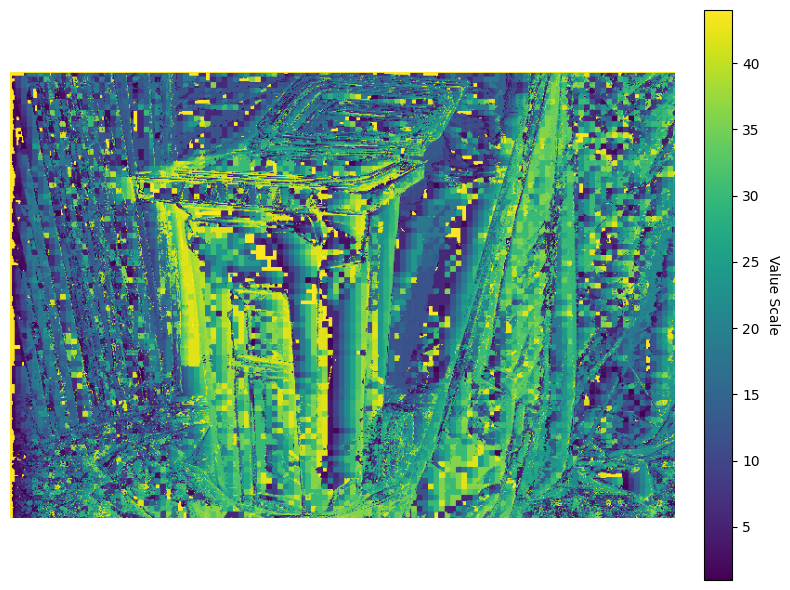

In [23]:
search_scale = 0.06

search = int(search_scale * gray_array_l.shape[1])

disp_matrix = generate_disparity(gray_array_l,gray_array_r,texture_l,texture_r,dict_l,dict_r,search,max_text)

disp_matrix = fill_missing_values(disp_matrix)

print("Search Distance - ",search)


plot_disp_array(disp_matrix)
# print(disp_matrix)
# print(np.max(disp_matrix))
# print(np.min(disp_matrix))
# print(np.mean(disp_matrix))


In [ ]:
# render_object(rgb_l,disp_matrix,resize_scale,20)



In [ ]:
import numpy as np
import cv2

import numpy as np
from scipy.ndimage import generic_filter

import numpy as np

def smooth_disparity_gradient(matrix, threshold=0.4, kernel_size=4, sigma=1.5):
    
    # Normalize to [0,1]
    min_val, max_val = np.min(matrix), np.max(matrix)
    if max_val == min_val:
        return matrix.copy()  # All values identical
    
    normalized = (matrix - min_val) / (max_val - min_val)
    
    # Start with a copy of normalized values (so unchanged blocks remain the same)
    processed = normalized.copy()
    
    for i in range(0, normalized.shape[0], kernel_size):
        for j in range(0, normalized.shape[1], kernel_size):
            
            # Extract kernel-sized block
            block = normalized[i:i+kernel_size, j:j+kernel_size]
            if len(block) == 0:  # Skip empty edge cases
                continue

            median_val = np.median(block)
            
            # Smooth the block only where it exceeds threshold
            smooth_block = np.where(
                np.abs(block - median_val) / (median_val + 1e-8) > threshold,  # avoid div by zero
                block - (block - median_val) * sigma,
                block
            )
            
            processed[i:i+kernel_size, j:j+kernel_size] = smooth_block
    
    # Denormalize and return
    return processed * (max_val - min_val) + min_val


smoothed = smooth_disparity_gradient(disp_matrix)

for _ in tqdm(range(10)):
    smoothed = smooth_disparity_gradient(smoothed,kernel_size=6)
    
# for _ in tqdm(range(20)):
#     smoothed = smooth_disparity_gradient(smoothed,kernel_size=6)

plot_viridis_matrix(disp_matrix)
plot_viridis_matrix(smoothed)

In [ ]:
# render_object(rgb_l,smoothed,resize_scale,10)